In [7]:
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve

from sklearn.ensemble import RandomForestClassifier


In [141]:
df_raw = pd.read_csv('Jan_2019_ontime.csv')

In [142]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           583985 non-null  int64  
 1   DAY_OF_WEEK            583985 non-null  int64  
 2   OP_UNIQUE_CARRIER      583985 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  583985 non-null  int64  
 4   OP_CARRIER             583985 non-null  object 
 5   TAIL_NUM               581442 non-null  object 
 6   OP_CARRIER_FL_NUM      583985 non-null  int64  
 7   ORIGIN_AIRPORT_ID      583985 non-null  int64  
 8   ORIGIN_AIRPORT_SEQ_ID  583985 non-null  int64  
 9   ORIGIN                 583985 non-null  object 
 10  DEST_AIRPORT_ID        583985 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    583985 non-null  int64  
 12  DEST                   583985 non-null  object 
 13  DEP_TIME               567633 non-null  float64
 14  DEP_DEL15              567630 non-nu

In [143]:
df_raw.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [144]:
df_raw = df_raw[df_raw['DIVERTED'] == 0]
df_raw = df_raw[df_raw['CANCELLED'] == 0]

In [145]:
df = df_raw[['DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'DEP_TIME_BLK', 'ORIGIN', 'DEST', 'DISTANCE', 'ARR_DEL15']]

In [146]:
df.dropna()
df = df.reset_index(drop=True)

In [147]:
df = df.rename(columns = {'DAY_OF_WEEK' : 'ON_WEEKEND'})
df['ON_WEEKEND'] = (df['ON_WEEKEND'] > 5).astype(int)

In [148]:
carrier_df = df[['OP_UNIQUE_CARRIER','ARR_DEL15']].groupby('OP_UNIQUE_CARRIER').sum().sort_values(by='ARR_DEL15',ascending=False)
carrier_df['CARRIER_cat'] = pd.qcut(carrier_df['ARR_DEL15'], 17, labels = False)
carrier_df

,ARR_DEL15,CARRIER_cat
OP_UNIQUE_CARRIER,,
WN,16111.0,16
OO,14024.0,15
AA,13741.0,14
DL,9403.0,13
UA,9156.0,12
B6,6429.0,11
YX,5864.0,10
MQ,5844.0,9
9E,4013.0,8


In [149]:
data_carrier = carrier_df.loc[df['OP_UNIQUE_CARRIER']].reset_index()
df['CARRIER_cat'] = data_carrier['CARRIER_cat']

In [150]:
time_blk_df = df[['DEP_TIME_BLK','ARR_DEL15']].groupby('DEP_TIME_BLK').sum().sort_values(by='ARR_DEL15',ascending=False)
time_blk_df['TIME_cat'] = pd.qcut(time_blk_df['ARR_DEL15'], 19, labels = False)
time_blk_df

,ARR_DEL15,TIME_cat
DEP_TIME_BLK,,
1700-1759,8270.0,18
1800-1859,7978.0,17
1600-1659,7576.0,16
1400-1459,7290.0,15
1500-1559,7281.0,14
1900-1959,7219.0,13
1200-1259,6639.0,12
1300-1359,6398.0,11
1100-1159,6361.0,10


In [151]:
data_time = time_blk_df.loc[df['DEP_TIME_BLK']].reset_index()
df['DEP_TIME_cat'] = data_time['TIME_cat']

In [152]:
origin_df = df[['ORIGIN','ARR_DEL15']].groupby('ORIGIN').sum().sort_values(by='ARR_DEL15',ascending=False)
origin_df['ORIGIN_cat'] = pd.qcut(origin_df['ARR_DEL15'], 25, labels = False)
origin_df

,ARR_DEL15,ORIGIN_cat
ORIGIN,,
ORD,7655.0,24
DFW,4322.0,24
LGA,4075.0,24
ATL,4013.0,24
SFO,3562.0,24
...,...,...
BRW,2.0,0
ADK,1.0,0
CPR,1.0,0


In [153]:
data_origin = origin_df.loc[df['ORIGIN']].reset_index()
df['ORIGIN_cat'] = data_origin['ORIGIN_cat']

In [154]:
dest_df = df[['DEST','ARR_DEL15']].groupby('DEST').sum().sort_values(by='ARR_DEL15',ascending=False)
dest_df['DEST_cat'] = pd.qcut(dest_df['ARR_DEL15'], 25, labels = False)
dest_df

,ARR_DEL15,DEST_cat
DEST,,
ORD,6441.0,24
LGA,4836.0,24
DFW,4282.0,24
ATL,3931.0,24
SFO,3642.0,24
...,...,...
CPR,3.0,0
STC,2.0,0
PPG,2.0,0


In [155]:
data_dest = dest_df.loc[df['DEST']].reset_index()
df['DEST_cat'] = data_dest['DEST_cat']

In [156]:
final_df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'ORIGIN_cat', 'DEST_cat', 'DISTANCE', 'ARR_DEL15']]
final_df

,ON_WEEKEND,CARRIER_cat,DEP_TIME_cat,ORIGIN_cat,DEST_cat,DISTANCE,ARR_DEL15
0,0,8,4,12,24,300.0,0.0
1,0,8,15,23,22,596.0,0.0
2,0,8,12,24,22,229.0,0.0
3,0,8,14,14,24,223.0,0.0
4,0,8,13,24,8,579.0,0.0
...,...,...,...,...,...,...,...
565958,0,12,5,3,21,3801.0,0.0
565959,0,12,5,3,3,129.0,0.0
565960,0,12,6,3,5,129.0,0.0
565961,0,12,17,3,5,129.0,0.0


In [157]:
df_X = final_df.drop('ARR_DEL15', axis=1)
df_y = final_df[['ARR_DEL15']]

In [158]:
X = df_X.values
y = df_y.values

In [159]:
y = LabelBinarizer().fit_transform(y)

In [160]:
df_y.value_counts()


ARR_DEL15
0.0          460741
1.0          105222
dtype: int64

In [161]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [162]:
X = StandardScaler().fit_transform(X)
X = MinMaxScaler().fit_transform(X)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [164]:
model = RandomForestClassifier()
model = model.fit(X_train, y_train)

In [165]:
y_pred_test = model.predict(X_test)

In [166]:
print(confusion_matrix(y_test, y_pred_test))


[[69991 22146]
 [19709 72451]]


In [167]:
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.78      0.76      0.77     92137
           1       0.77      0.79      0.78     92160

    accuracy                           0.77    184297
   macro avg       0.77      0.77      0.77    184297
weighted avg       0.77      0.77      0.77    184297



/home/tomaz/anaconda3/envs/clean/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


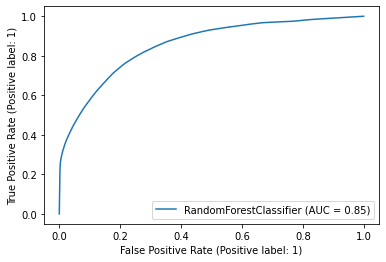

In [168]:
plot_roc_curve(model, X_test, y_test)


In [171]:
def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

In [175]:
feature_importance(df_X.columns.to_list(), model)


,feature,value
0,DISTANCE,0.292442
1,DEP_TIME_cat,0.239372
2,ON_WEEKEND,0.189500
3,CARRIER_cat,0.109730
4,ORIGIN_cat,0.085319
5,DEST_cat,0.083637


In [4]:
from graphdatascience import GraphDataScience

host = 'bolt://localhost:7687'
user = 'neo4j'
password = 'letmein'

gds = GraphDataScience(host, auth=(user,password))


In [5]:
print(gds.version())


2.0.3


In [9]:
df_raw

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583980,31,4,UA,19977,UA,N776UA,200,12016,1201602,GUM,...,HNL,749.0,0.0,0700-0759,1832.0,0.0,0.0,0.0,3801.0,NaN
583981,31,4,UA,19977,UA,N36280,174,12016,1201602,GUM,...,SPN,717.0,0.0,0700-0759,759.0,0.0,0.0,0.0,129.0,NaN
583982,31,4,UA,19977,UA,N36280,117,14955,1495503,SPN,...,GUM,857.0,0.0,0900-0959,933.0,0.0,0.0,0.0,129.0,NaN
583983,31,4,UA,19977,UA,N39726,105,14955,1495503,SPN,...,GUM,1820.0,0.0,1800-1859,1854.0,0.0,0.0,0.0,129.0,NaN


In [59]:
#import airports
airports = df_raw['ORIGIN'].unique().tolist()

gds.run_cypher("""
UNWIND $data AS airport_id
CREATE (:Airport {id: airport_id})
""", {'data': airports})


""


In [60]:
# import connections

connections = df_raw.groupby(['DEST', 'ORIGIN']).size().to_frame('count').reset_index()

gds.run_cypher("""
UNWIND $data AS row
MATCH (origin:Airport {id: row.ORIGIN})
MATCH (target:Airport {id: row.DEST})
MERGE (origin)-[c:CONNECTION]->(target)
SET c.count = row.count
""", {'data': connections.to_dict('records')})

""


In [61]:
G, res = gds.graph.project('airports','Airport', 'CONNECTION', relationshipProperties=['count'])

In [126]:
# Betweenness centrality

bc = gds.betweenness.stream(G)
bc['airport_id'] = [n.get('id') for n in gds.util.asNodes(bc['nodeId'].to_list())]
bc = bc[['airport_id', 'score']].set_index('airport_id')

In [127]:
dest_bc = bc.loc[df['DEST']].reset_index()
origin_bc = bc.loc[df['ORIGIN']].reset_index()


In [128]:
df['ORIGIN_bc'] = origin_bc['score']
df['DEST_bc'] = dest_bc['score']

In [129]:
final_df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'ORIGIN_cat', 'DEST_cat', 'DISTANCE', 'ARR_DEL15', 'ORIGIN_bc', 'DEST_bc']]

In [139]:
def get_roc_curve(df):
    df_X = final_df.drop('ARR_DEL15', axis=1)
    df_y = final_df[['ARR_DEL15']]

    X = df_X.values
    y = df_y.values

    y = LabelBinarizer().fit_transform(y)

    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)

    X = StandardScaler().fit_transform(X)
    X = MinMaxScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    model = RandomForestClassifier()
    model = model.fit(X_train, y_train)
    
    y_pred_test = model.predict(X_test)
    
    return plot_roc_curve(model, X_test, y_test)

/home/tomaz/anaconda3/envs/clean/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


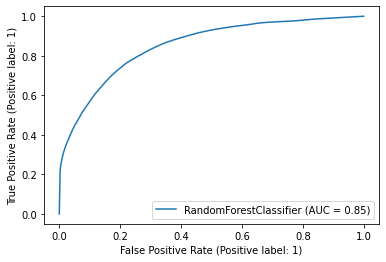

In [140]:
get_roc_curve(final_df)

In [134]:
# embeddings

In [62]:
res

nodeProjection            {'Airport': {'label': 'Airport', 'properties':...
relationshipProjection    {'CONNECTION': {'orientation': 'NATURAL', 'agg...
graphName                                                          airports
nodeCount                                                               346
relationshipCount                                                      5532
projectMillis                                                            32
Name: 0, dtype: object

In [63]:
airport_embeddings = gds.fastRP.stream(G, embeddingDimension=28, relationshipWeightProperty='count')

In [64]:
airport_embeddings['airport_id'] = [n.get('id') for n in gds.util.asNodes(airport_embeddings['nodeId'].to_list())]

In [80]:
airport_embeddings = airport_embeddings[['airport_id', 'embedding']].set_index('airport_id')

In [81]:
airport_embeddings

,embedding
airport_id,
GNV,"[-0.3157918453216553, 0.26132383942604065, -0...."
MSP,"[-0.1396445333957672, 0.5960660576820374, -0.1..."
DTW,"[-0.2511483132839203, 0.45610305666923523, -0...."
TLH,"[-0.27731481194496155, 0.29104262590408325, -0..."
ATL,"[-0.2067861706018448, 0.3942330479621887, -0.2..."
...,...
OWB,"[-0.2313401699066162, 0.396729052066803, 0.087..."
OGS,"[-0.262594997882843, 0.39020735025405884, 0.10..."
PPG,"[0.14968064427375793, 0.022071614861488342, -0..."


In [84]:
dest_embedding = airport_embeddings.loc[df['DEST']].reset_index()
origin_embedding = airport_embeddings.loc[df['ORIGIN']].reset_index()


In [87]:
df['ORIGIN_emb'] = origin_embedding['embedding']
df['DEST_emb'] = dest_embedding['embedding']

In [104]:
final_df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'ORIGIN_cat', 'DEST_cat', 'DISTANCE', 'ARR_DEL15', 'ORIGIN_emb', 'DEST_emb']]

In [105]:
final_df

,ON_WEEKEND,CARRIER_cat,DEP_TIME_cat,ORIGIN_cat,DEST_cat,DISTANCE,ARR_DEL15,ORIGIN_emb,DEST_emb
0,0,8,4,12,24,300.0,0.0,"[-0.3157918453216553, 0.26132383942604065, -0....","[-0.2067861706018448, 0.3942330479621887, -0.2..."
1,0,8,15,23,22,596.0,0.0,"[-0.1396445333957672, 0.5960660576820374, -0.1...","[-0.22740711271762848, 0.41919374465942383, -0..."
2,0,8,12,24,22,229.0,0.0,"[-0.2511483132839203, 0.45610305666923523, -0....","[-0.22740711271762848, 0.41919374465942383, -0..."
3,0,8,14,14,24,223.0,0.0,"[-0.27731481194496155, 0.29104262590408325, -0...","[-0.2067861706018448, 0.3942330479621887, -0.2..."
4,0,8,13,24,8,579.0,0.0,"[-0.2067861706018448, 0.3942330479621887, -0.2...","[-0.08221516758203506, 0.40266746282577515, -0..."
...,...,...,...,...,...,...,...,...,...
565958,0,12,5,3,21,3801.0,0.0,"[-0.11222155392169952, 0.011598668992519379, -...","[0.20049530267715454, 0.3754225969314575, -0.3..."
565959,0,12,5,3,3,129.0,0.0,"[-0.11222155392169952, 0.011598668992519379, -...","[-0.15916235744953156, -0.07672090083360672, -..."
565960,0,12,6,3,5,129.0,0.0,"[-0.15916235744953156, -0.07672090083360672, -...","[-0.11222155392169952, 0.011598668992519379, -..."
565961,0,12,17,3,5,129.0,0.0,"[-0.15916235744953156, -0.07672090083360672, -...","[-0.11222155392169952, 0.011598668992519379, -..."


In [106]:
origin_df = pd.DataFrame(df['ORIGIN_emb'].tolist(), columns= [f'ORIGIN_emb_{i}' for i in range(0,28) ])
dest_df = pd.DataFrame(df['DEST_emb'].tolist(), columns= [f'DEST_emb_{i}' for i in range(0,28) ] )

In [108]:
final_df = pd.concat([final_df, origin_df], axis=1)
#

In [110]:
final_df = pd.concat([final_df, dest_df], axis=1)

In [111]:
final_df

,ON_WEEKEND,CARRIER_cat,DEP_TIME_cat,ORIGIN_cat,DEST_cat,DISTANCE,ARR_DEL15,ORIGIN_emb,DEST_emb,ORIGIN_emb_0,...,DEST_emb_18,DEST_emb_19,DEST_emb_20,DEST_emb_21,DEST_emb_22,DEST_emb_23,DEST_emb_24,DEST_emb_25,DEST_emb_26,DEST_emb_27
0,0,8,4,12,24,300.0,0.0,"[-0.3157918453216553, 0.26132383942604065, -0....","[-0.2067861706018448, 0.3942330479621887, -0.2...",-0.315792,...,0.268994,0.263794,0.750712,0.379015,0.413253,0.215008,-0.384602,0.411757,0.224273,-0.210626
1,0,8,15,23,22,596.0,0.0,"[-0.1396445333957672, 0.5960660576820374, -0.1...","[-0.22740711271762848, 0.41919374465942383, -0...",-0.139645,...,0.348720,0.310006,0.711668,0.388299,0.334783,0.211844,-0.350932,0.409810,0.227260,-0.222040
2,0,8,12,24,22,229.0,0.0,"[-0.2511483132839203, 0.45610305666923523, -0....","[-0.22740711271762848, 0.41919374465942383, -0...",-0.251148,...,0.348720,0.310006,0.711668,0.388299,0.334783,0.211844,-0.350932,0.409810,0.227260,-0.222040
3,0,8,14,14,24,223.0,0.0,"[-0.27731481194496155, 0.29104262590408325, -0...","[-0.2067861706018448, 0.3942330479621887, -0.2...",-0.277315,...,0.268994,0.263794,0.750712,0.379015,0.413253,0.215008,-0.384602,0.411757,0.224273,-0.210626
4,0,8,13,24,8,579.0,0.0,"[-0.2067861706018448, 0.3942330479621887, -0.2...","[-0.08221516758203506, 0.40266746282577515, -0...",-0.206786,...,0.111497,0.170220,0.625053,0.459303,0.371375,0.017857,-0.450738,0.430408,0.177210,-0.285707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565958,0,12,5,3,21,3801.0,0.0,"[-0.11222155392169952, 0.011598668992519379, -...","[0.20049530267715454, 0.3754225969314575, -0.3...",-0.112222,...,-0.224152,0.080462,0.211983,0.240571,-0.141744,0.065605,-0.085005,-0.190373,0.020327,-0.151129
565959,0,12,5,3,3,129.0,0.0,"[-0.11222155392169952, 0.011598668992519379, -...","[-0.15916235744953156, -0.07672090083360672, -...",-0.112222,...,-0.101333,0.146944,0.071806,0.149449,-0.102295,-0.080381,-0.193818,-0.281141,0.062978,0.096395
565960,0,12,6,3,5,129.0,0.0,"[-0.15916235744953156, -0.07672090083360672, -...","[-0.11222155392169952, 0.011598668992519379, -...",-0.159162,...,-0.252516,0.071398,0.129695,0.205212,-0.129075,0.019833,-0.190777,-0.342259,0.044244,-0.028932
565961,0,12,17,3,5,129.0,0.0,"[-0.15916235744953156, -0.07672090083360672, -...","[-0.11222155392169952, 0.011598668992519379, -...",-0.159162,...,-0.252516,0.071398,0.129695,0.205212,-0.129075,0.019833,-0.190777,-0.342259,0.044244,-0.028932


In [112]:
df_X = final_df.drop(['ARR_DEL15', 'ORIGIN_emb', 'DEST_emb'], axis=1)
df_y = final_df[['ARR_DEL15']]

In [113]:
X = df_X.values
y = df_y.values

In [114]:
y = LabelBinarizer().fit_transform(y)

In [115]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [116]:
X = StandardScaler().fit_transform(X)
X = MinMaxScaler().fit_transform(X)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [118]:
model = RandomForestClassifier()
model = model.fit(X_train, y_train)

In [119]:
y_pred_test = model.predict(X_test)

In [120]:
print(confusion_matrix(y_test, y_pred_test))


[[70436 21825]
 [20078 71958]]


In [121]:
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.78      0.76      0.77     92261
           1       0.77      0.78      0.77     92036

    accuracy                           0.77    184297
   macro avg       0.77      0.77      0.77    184297
weighted avg       0.77      0.77      0.77    184297



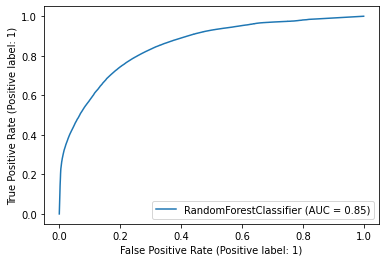

In [123]:
plot_roc_curve(model, X_test, y_test)
